# Importing Necessary Libraries

In [146]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os

# Check for GPU/CPU

In [147]:
print(tf.config.list_physical_devices('GPU'))
assert tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Importing and Splitting dataset into Train, Test and Valid

In [148]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [220]:
train_datagen = ImageDataGenerator(rescale = 1 / 255)
val_datagen = ImageDataGenerator(rescale = 1 / 255)
test_datagen = ImageDataGenerator(rescale = 1 / 255)

batch_size = 32
img_height = 224
img_width = 224
num_classes = 26
learning_rate = 0.001
dropout_rate = 0.5

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    'dataset/valid',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3876 images belonging to 26 classes.
Found 130 images belonging to 26 classes.
Found 130 images belonging to 26 classes.


# Visualizing the data

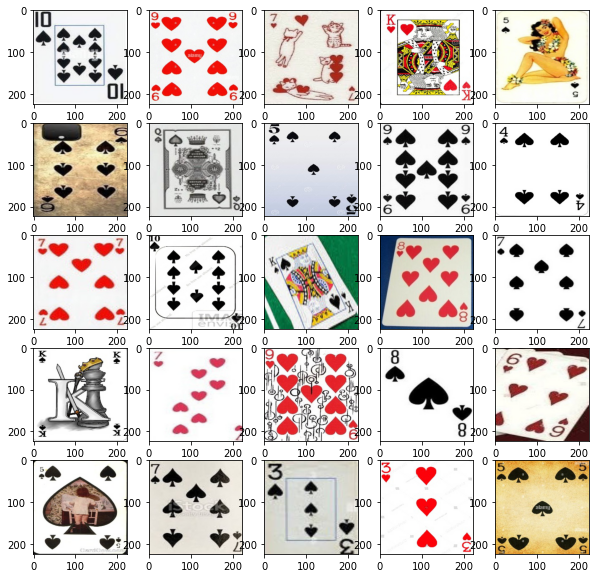

In [221]:
images, labels = next(train_generator)

fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])

# Import Libraries and the pre-trained network VGG16

In [222]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Create the Model

In [231]:
def vgg_model(num_classes, learning_rate, dropout_rate):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3)) #load the pre-trained model

    #Freezing the layers
    for layer in vgg16.layers:
        layer.trainable = False

    x = vgg16.output

    #Adding our own convolution layers and pooling layers
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), padding = 'same')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=vgg16.input, outputs=x)

    #Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

In [232]:
model = vgg_model(num_classes, learning_rate, dropout_rate)

# Define a Learning rate Scheduler

In [233]:
def lr_schedule(epoch, lr):
    if epoch % 7 == 0 and epoch != 0:
        return lr * 0.2
    else:
        return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [234]:
bot = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[lr_scheduler])

Epoch 1/25
122/122 [==============================] - 15s 113ms/step - loss: 2.8252 - accuracy: 0.1618 - val_loss: 1.7430 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 2/25
122/122 [==============================] - 12s 101ms/step - loss: 1.7651 - accuracy: 0.4422 - val_loss: 1.0744 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 3/25
122/122 [==============================] - 12s 102ms/step - loss: 1.3025 - accuracy: 0.5911 - val_loss: 0.8226 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 4/25
122/122 [==============================] - 12s 99ms/step - loss: 1.0370 - accuracy: 0.6829 - val_loss: 0.6001 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 5/25
122/122 [==============================] - 13s 103ms/step - loss: 0.8076 - accuracy: 0.7513 - val_loss: 0.4760 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 6/25
122/122 [==============================] - 12s 99ms/step - loss: 0.6839 - accuracy: 0.7884 - val_loss: 0.4418 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 7/25
122/122 [==============================] - 

# Test the model

In [235]:
test = model.evaluate(test_generator)
print('Test loss:', test[0])
print('Test accuracy:', test[1])

5/5 [==============================] - 1s 138ms/step - loss: 0.5345 - accuracy: 0.8462
Test loss: 0.5345203280448914
Test accuracy: 0.8461538553237915


# Plot the Loss Vs Epochs Curve

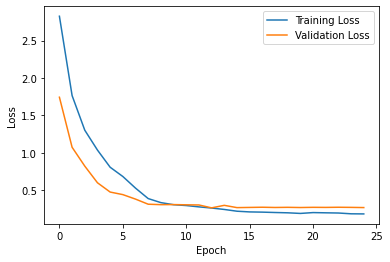

In [236]:
plt.plot(bot.history['loss'], label='Training Loss')
plt.plot(bot.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

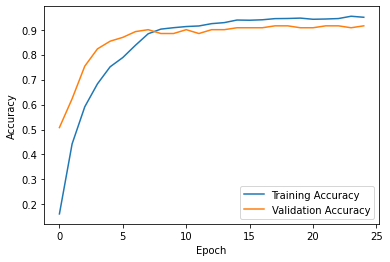

In [237]:
plt.plot(bot.history['accuracy'], label='Training Accuracy')
plt.plot(bot.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [241]:
from sklearn.metrics import confusion_matrix

true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
pred_labels = np.argmax(model.predict(test_generator), axis=1)

conf_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels)

print(conf_mat)

tf.Tensor(
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]